# Simulated Galaxies: The Return

What we want in this notebook is to create and test several schemes to generate galaxy images. 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import galsim
import tensorflow as tf
import tensorflow_datasets as tfds
import autometacal
import tqdm

In [3]:
(datat, datav), ds_info = tfds.load('gal_gen/simple_100k',split=['train[:14%]', 'train[14%:20%]'],with_info=True)
datat = datat.cache()
datat = datat.shuffle(ds_info.splits['train'].num_examples)
datat = datat.batch(10000)
datat = datat.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
data = datat.take(1)
datait = data.as_numpy_iterator()
test=datait.next()

In [5]:
sum(test['gal_image'][1])

104063.836

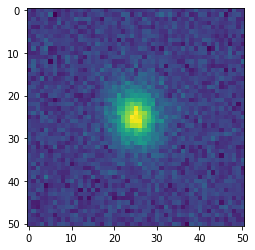

In [6]:
imshow(test['gal_image'][3])

In [ ]:
def make_data(Ngals=1,
  snr = 200,
  scale = 0.2,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0], 
  flux=1.e5):
  """Simple exponetial profile toy model galaxy"""
  
  gal_list = []
  psf_list = []
 
  for n in range(Ngals):
    psf = galsim.Moffat(beta=2.5, 
                      fwhm=psf_fwhm)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr,flux=flux).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    noise = galsim.GaussianNoise()
    gal_image.addNoiseSNR(noise,snr=snr,preserve_flux=True)
    
    gal_image = tf.convert_to_tensor(gal_image.array)
    psf_image = tf.convert_to_tensor(psf_image)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
  
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  
  return gal_image_stack, psf_image_stack

In [ ]:
gal_images =
psf_images =

# Autodiff Test

In [7]:
def line_and_contours(lines,percentiles=[2.5,16,50,84,97.5]):
  line_and_contours = np.percentile(lines,percentiles,axis=1)
  return line_and_contours

In [8]:
steps = logspace(-5,0,100)

In [10]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=0.9*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(
  reconv_psf.drawImage(nx=51, 
                       ny=51, 
                       scale=.2).array),axis=0)

In [11]:
def get_ellipticities(image):
  return autometacal.gaussian_moments(image,0.2,1.2)

In [12]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = autometacal.metacal.get_metacal_response_finitediff(gal_images,
                                                         psf_images,
                                                         reconv_psf_image,
                                                         step=step,method=get_ellipticities)
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)

  0%|          | 0/100 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████| 100/100 [06:44<00:00,  4.04s/it]


In [13]:
e_auto, R_auto = autometacal.get_metacal_response(gal_images[:2500],psf_images[:2500],reconv_psf_image,get_ellipticities)
calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

e_auto1, R_auto1 = autometacal.get_metacal_response(gal_images[2500:],psf_images[2500:],reconv_psf_image,get_ellipticities)
calibre_f1=tf.linalg.inv(R_auto1[:]) @ tf.reshape(e_auto1,[-1,2,1])

e_auto = tf.concat([e_auto,e_auto1],axis=0)
R_auto = tf.concat([R_auto,R_auto1],axis=0)
calibre_f=tf.concat([calibre_f,calibre_f1],axis=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


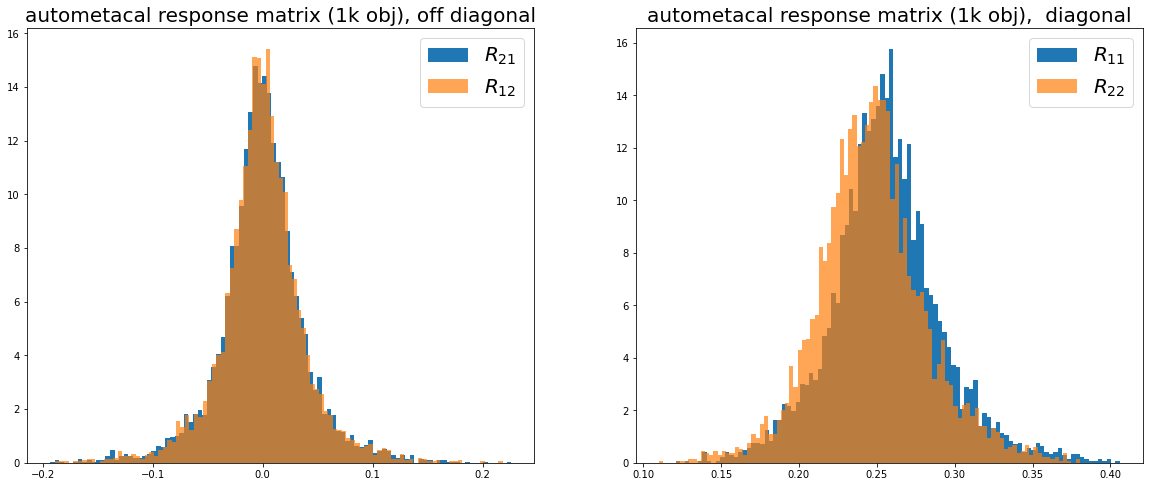

In [14]:
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[abs(e_auto[:,0])<1],bins=100,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[abs(e_auto[:,0])<1],bins=100,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_simple.png',bbox_inches='tight')

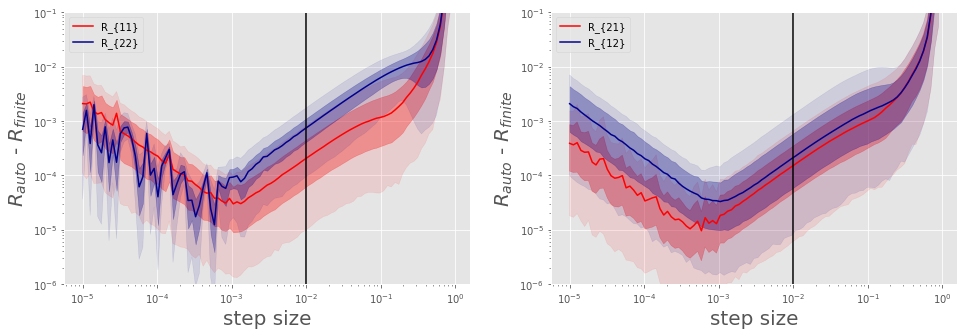

In [15]:
style.use('ggplot')

figure(figsize=(16,5))
subplot(121)

Y00_95, Y00_84, Y00_median, Y00_16, Y00_5 = line_and_contours(abs(R_auto[:,0,0]-R_finite[:,:,0,0]))
fill_between(steps, Y00_5,Y00_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y00_16,Y00_84,color='red',alpha=0.3)####CL68
plot(steps,Y00_median,label="R_{11}",color='red')####Median 

Y11_95, Y11_84, Y11_median, Y11_16, Y11_5 = line_and_contours(abs(R_auto[:,1,1]-R_finite[:,:,1,1]))
fill_between(steps, Y11_5,Y11_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y11_16,Y11_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y11_median,label="R_{22}",color='darkblue')####Median 
plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel('$R_{auto}$ - $R_{finite}$',fontsize=20)
legend()
xscale('log')
yscale('log')

subplot(122)

Y10_95, Y10_84, Y10_median, Y10_16, Y10_5 = line_and_contours(abs(R_auto[:,1,0]-R_finite[:,:,1,0]))
fill_between(steps, Y10_5,Y10_95,color='red',alpha=0.1)####CL95
fill_between(steps, Y10_16,Y10_84,color='red',alpha=0.3)####CL68
plot(steps,Y10_median,label="R_{21}",color='red')####Median 

Y01_95, Y01_84, Y01_median, Y01_16, Y01_5 = line_and_contours(abs(R_auto[:,0,1]-R_finite[:,:,0,1]))
fill_between(steps, Y01_5,Y01_95,color='darkblue',alpha=0.1)####CL95
fill_between(steps, Y01_16,Y01_84,color='darkblue',alpha=0.3)####CL68
plot(steps,Y01_median,label="R_{12}",color='darkblue')####Median 

plot([1e-2,1e-2],[1e-6,1e-1],'k-')

ylim([1e-6,1e-1])
xlabel('step size',fontsize=20)
ylabel("$R_{auto}$ - $R_{finite}$",fontsize=20)
legend()
xscale('log')
yscale('log')
savefig('simple.png',bbox_inches='tight')